In [40]:
# import sys
# sys.path.append('../')
# from kaggle_dataset_downloader import download_kaggle_dataset
# download_kaggle_dataset("abrambeyer/openintro-possum", "./")

Can we use total length to predict a possum's head length?<br>
Which possum body dimensions are most correlated with age and sex?<br>
Can we classify a possum's sex by its body dimensions and location? <br>
Can we predict a possum's trapping location from its body dimensions? <br>

### <font color = 'blue'>Features </font><br>
case<br>
site of recording<br>
population area<br>
sex<br>
age<br>
head length<br>
skull width<br>
total length<br>
tail length<br>
foot length<br>
ear conch length<br>
eye size<br>
chest girt<br>
belly girt<br>


- Can we use total length to predict a possum's head length?<br>
- Which possum body dimensions are most correlated with age and sex?<br>
- Can we classify a possum's sex by its body dimensions and location?<br>
- Can we predict a possum's trapping location from its body dimensions?<br>



In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import gaussian_kde
from itertools import combinations
from scipy import stats

**Importing possum dataset and inspecting the structure, dtypes, missing values and statistical features**

In [42]:
df = pd.read_csv('./data/possum.csv')

In [43]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [44]:
df.Pop.value_counts()

Pop
other    58
Vic      46
Name: count, dtype: int64

In [45]:
df.sex.value_counts()

sex
m    61
f    43
Name: count, dtype: int64

**case column is just numbers to cound the enteries and we can drop it**

In [46]:
df.drop('case', axis=1, inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   site      104 non-null    int64  
 1   Pop       104 non-null    object 
 2   sex       104 non-null    object 
 3   age       102 non-null    float64
 4   hdlngth   104 non-null    float64
 5   skullw    104 non-null    float64
 6   totlngth  104 non-null    float64
 7   taill     104 non-null    float64
 8   footlgth  103 non-null    float64
 9   earconch  104 non-null    float64
 10  eye       104 non-null    float64
 11  chest     104 non-null    float64
 12  belly     104 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 10.7+ KB


**104 rows and 14 features (104 , 14). datatypes are consisted of object, int and float. we can also see that we have a few missing values**

In [48]:
df.isnull().sum()

site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [49]:
df.select_dtypes(include=['float']).describe()

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


**age and eye have lower range and std compared to other features. for the missing values we can simply fill them with mean values for each feature (age = 3.83 , footlgth = 68.45)**

In [50]:
df.fillna(df['age'].mean(), inplace=True)
df.fillna(df['footlgth'].mean(), inplace=True)

In [51]:
df.columns

Index(['site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [52]:
numerical_features = ['age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
def boxplot_per_feature(n, m , dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    # Plot each feature against target
    for i, feature in enumerate(numerical_features):
        ax[i].boxplot(dataset[feature])
        ax[i].set_xticklabels([feature], color = 'red')  
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')
    # Hide any empty subplots
    for i in range(len(dataset), len(ax)):
        ax[i].set_visible(False)
    plt.tight_layout()
    plt.show()



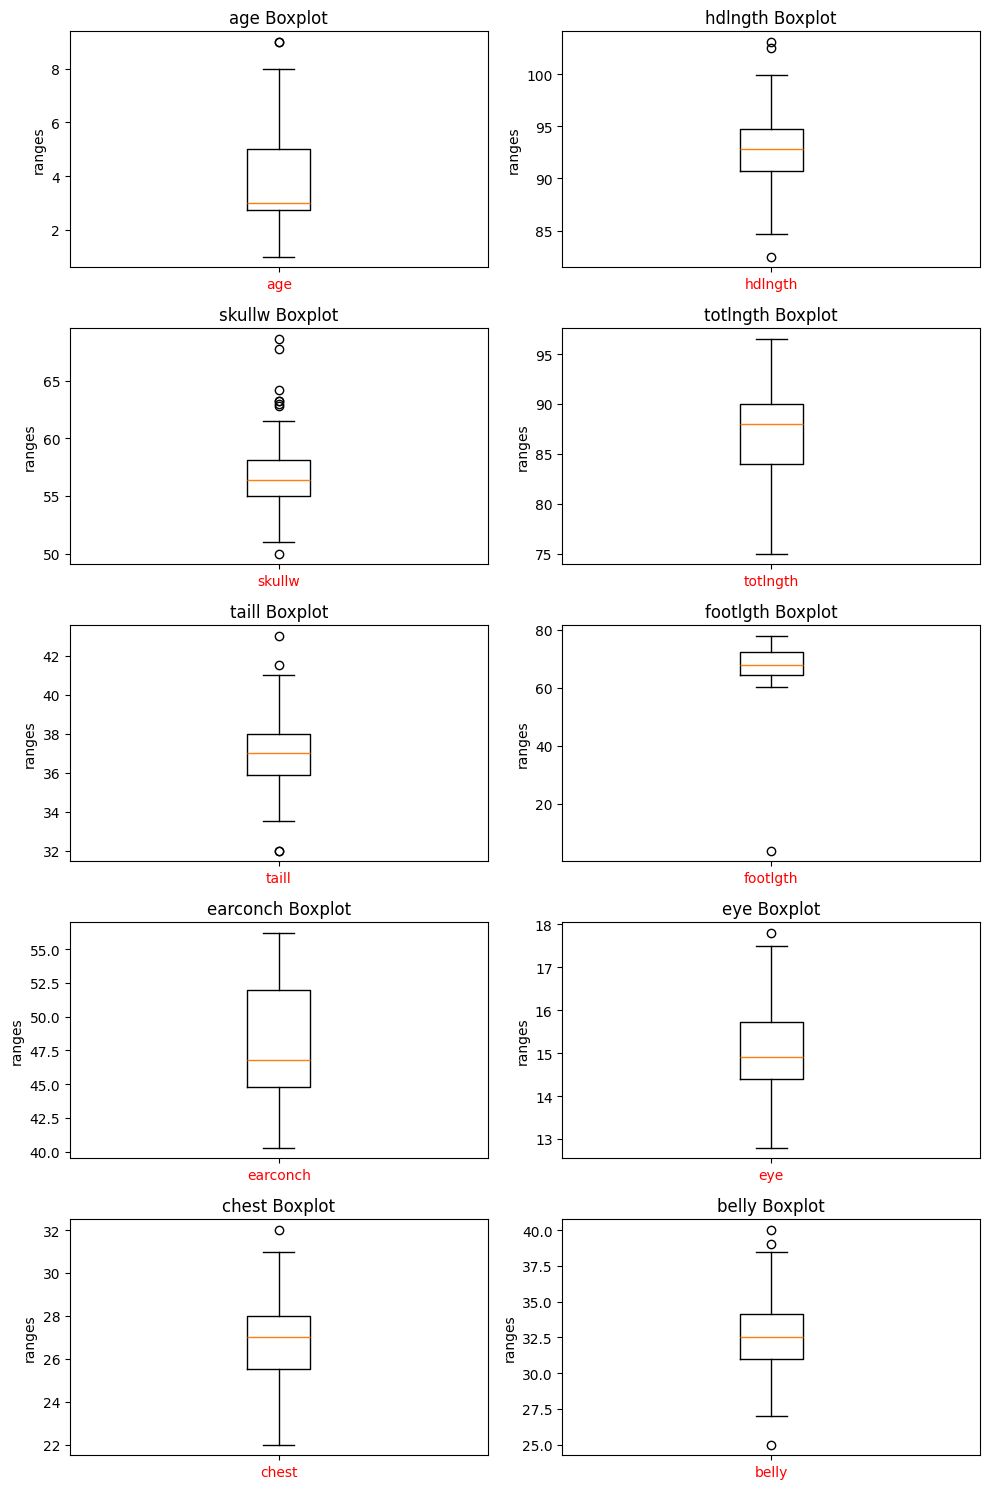

In [53]:
boxplot_per_feature(5, 2 ,df.select_dtypes(include=['float', 'int']))

In [54]:
numerical_features = ['age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
def violon_plot(n, m , dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    for i, feature in enumerate(numerical_features):
        ax[i].hist(dataset[feature], bins = 25, edgecolor ='black')
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')
    for i in range(len(dataset), len(ax)):
        ax[i].set_visible(False)
    plt.tight_layout()
    plt.show()

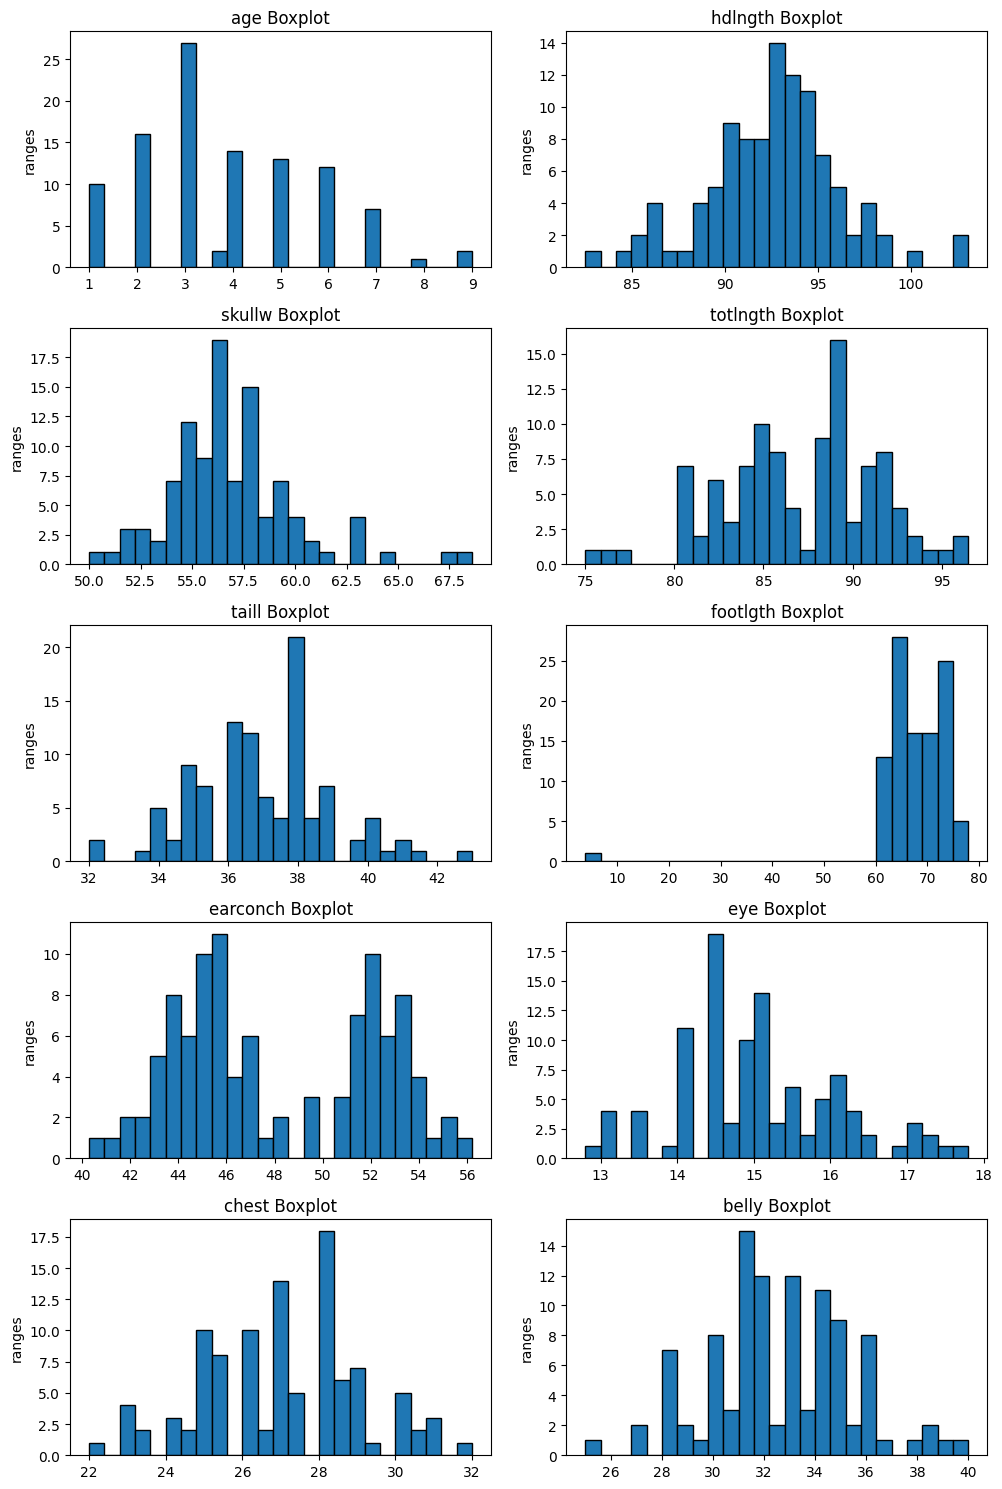

In [55]:
violon_plot(5, 2 ,df.select_dtypes(include=['float', 'int']))

My assumtion is that most of this istribution makes sense except for the very small footlenght which looks to be fully out of range. i will drop this row because it seems wrong

In [56]:
df.iloc[40]

site               2
Pop              Vic
sex                f
age              5.0
hdlngth         88.4
skullw          57.0
totlngth        83.0
taill           36.5
footlgth    3.833333
earconch        40.3
eye             15.9
chest           27.0
belly           30.5
Name: 40, dtype: object

In [57]:
df.drop(40, axis =0, inplace=True)

**seperating males and females data sets and comparing some of the features**

male poplution comparison of totlngth and hdlngth <br>
R2 value shows how well the line fits (1.0 = perfect fit, 0.0 = no correlation)

In [58]:
male_pop = df[df['sex'] == 'm']
female_pop = df[df['sex'] == 'f']

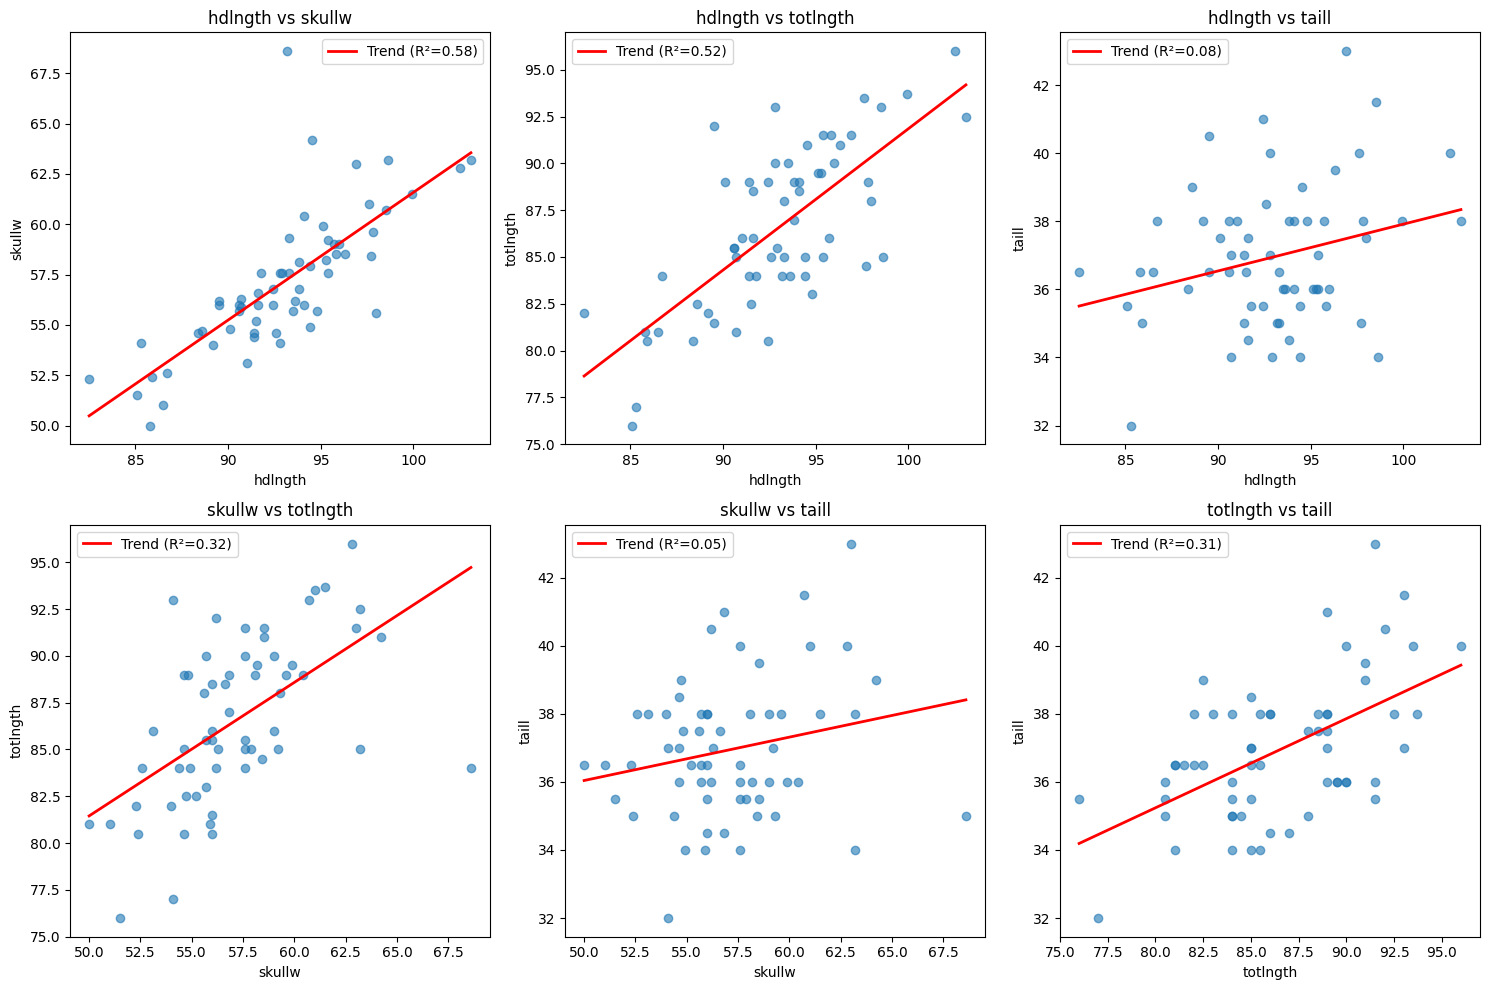

In [59]:
features = ['hdlngth', 'skullw', 'totlngth', 'taill']
pairs = list(combinations(features, 2))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ax = axes.flatten()

for i, (feature_x, feature_y) in enumerate(pairs):
    ax[i].scatter(male_pop[feature_x], male_pop[feature_y], alpha=0.6)
    
    # Add regression/trend line
    slope, intercept, r_value, _, _ = stats.linregress(male_pop[feature_x], male_pop[feature_y])
    line_x = np.linspace(male_pop[feature_x].min(), male_pop[feature_x].max(), 100)
    line_y = slope * line_x + intercept
    ax[i].plot(line_x, line_y, 'r-', linewidth=2, label=f'Trend (R²={r_value**2:.2f})')
    
    # # Mean lines
    # ax[i].axhline(female_pop[feature_y].mean(), color='green', linestyle='--', alpha=0.5, label='Mean Y')
    # ax[i].axvline(female_pop[feature_x].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean X')
    
    ax[i].set_xlabel(feature_x)
    ax[i].set_ylabel(feature_y)
    ax[i].set_title(f'{feature_x} vs {feature_y}')
    ax[i].legend()

plt.tight_layout()
plt.show()

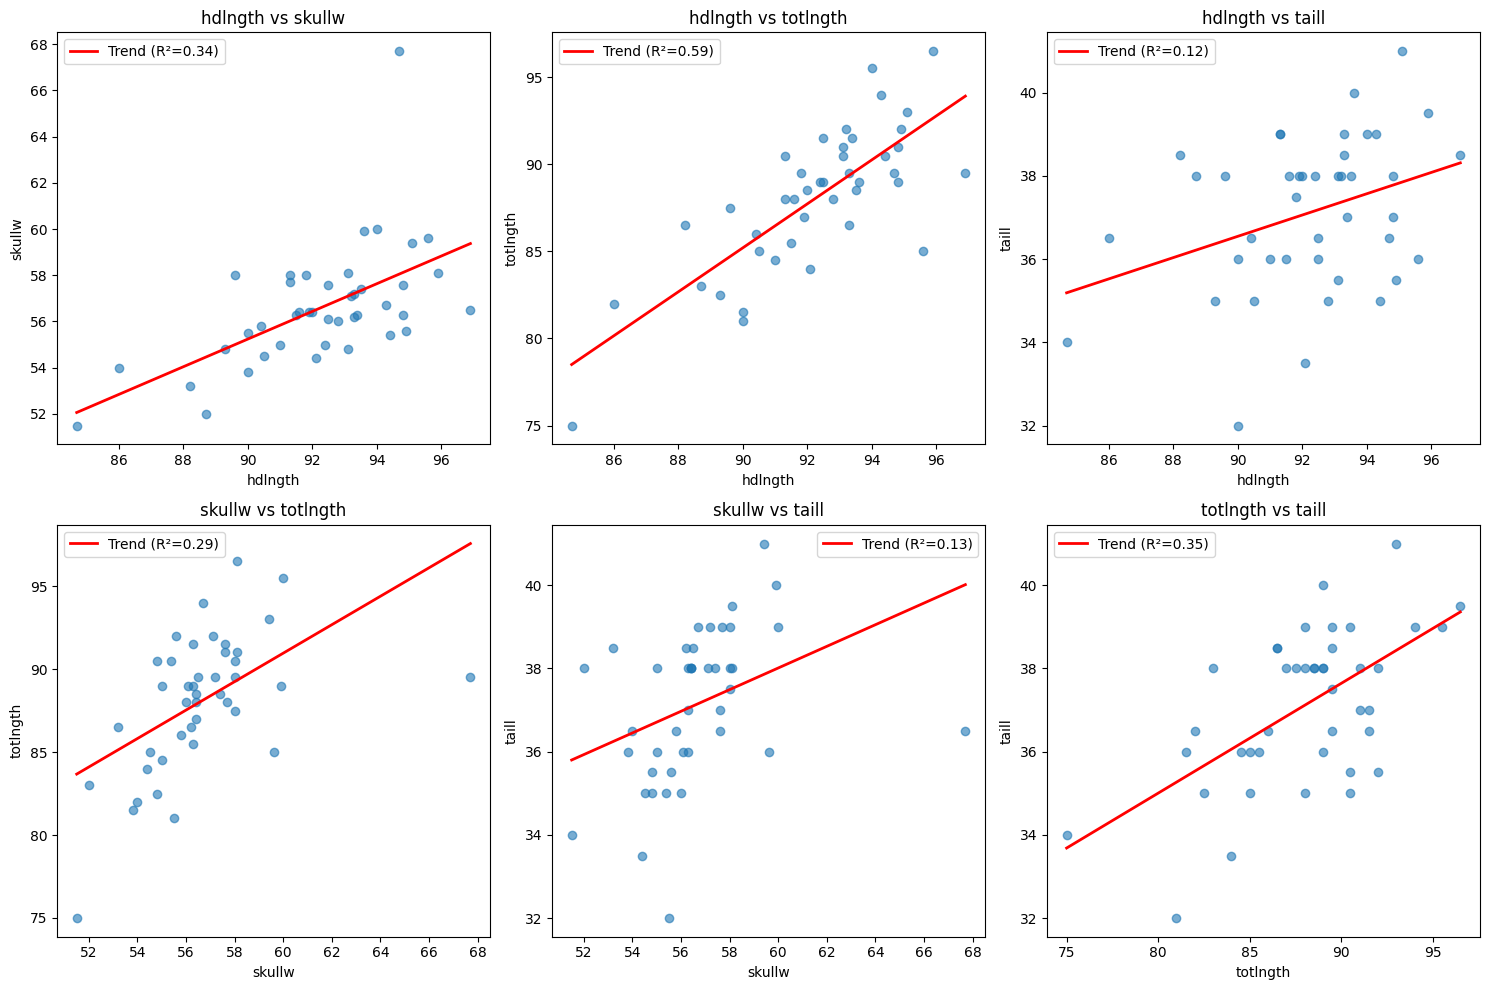

In [60]:
features = ['hdlngth', 'skullw', 'totlngth', 'taill']
pairs = list(combinations(features, 2))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ax = axes.flatten()

for i, (feature_x, feature_y) in enumerate(pairs):
    ax[i].scatter(female_pop[feature_x], female_pop[feature_y], alpha=0.6)
    
    # Add regression/trend line
    slope, intercept, r_value, _, _ = stats.linregress(female_pop[feature_x], female_pop[feature_y])
    line_x = np.linspace(female_pop[feature_x].min(), female_pop[feature_x].max(), 100)
    line_y = slope * line_x + intercept
    ax[i].plot(line_x, line_y, 'r-', linewidth=2, label=f'Trend (R²={r_value**2:.2f})')
    
    # # Mean lines
    # ax[i].axhline(female_pop[feature_y].mean(), color='green', linestyle='--', alpha=0.5, label='Mean Y')
    # ax[i].axvline(female_pop[feature_x].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean X')
    
    ax[i].set_xlabel(feature_x)
    ax[i].set_ylabel(feature_y)
    ax[i].set_title(f'{feature_x} vs {feature_y}')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [61]:
vic_pop = df[df['Pop'] == 'Vic']
other_pop = df[df['Pop'] == 'other']

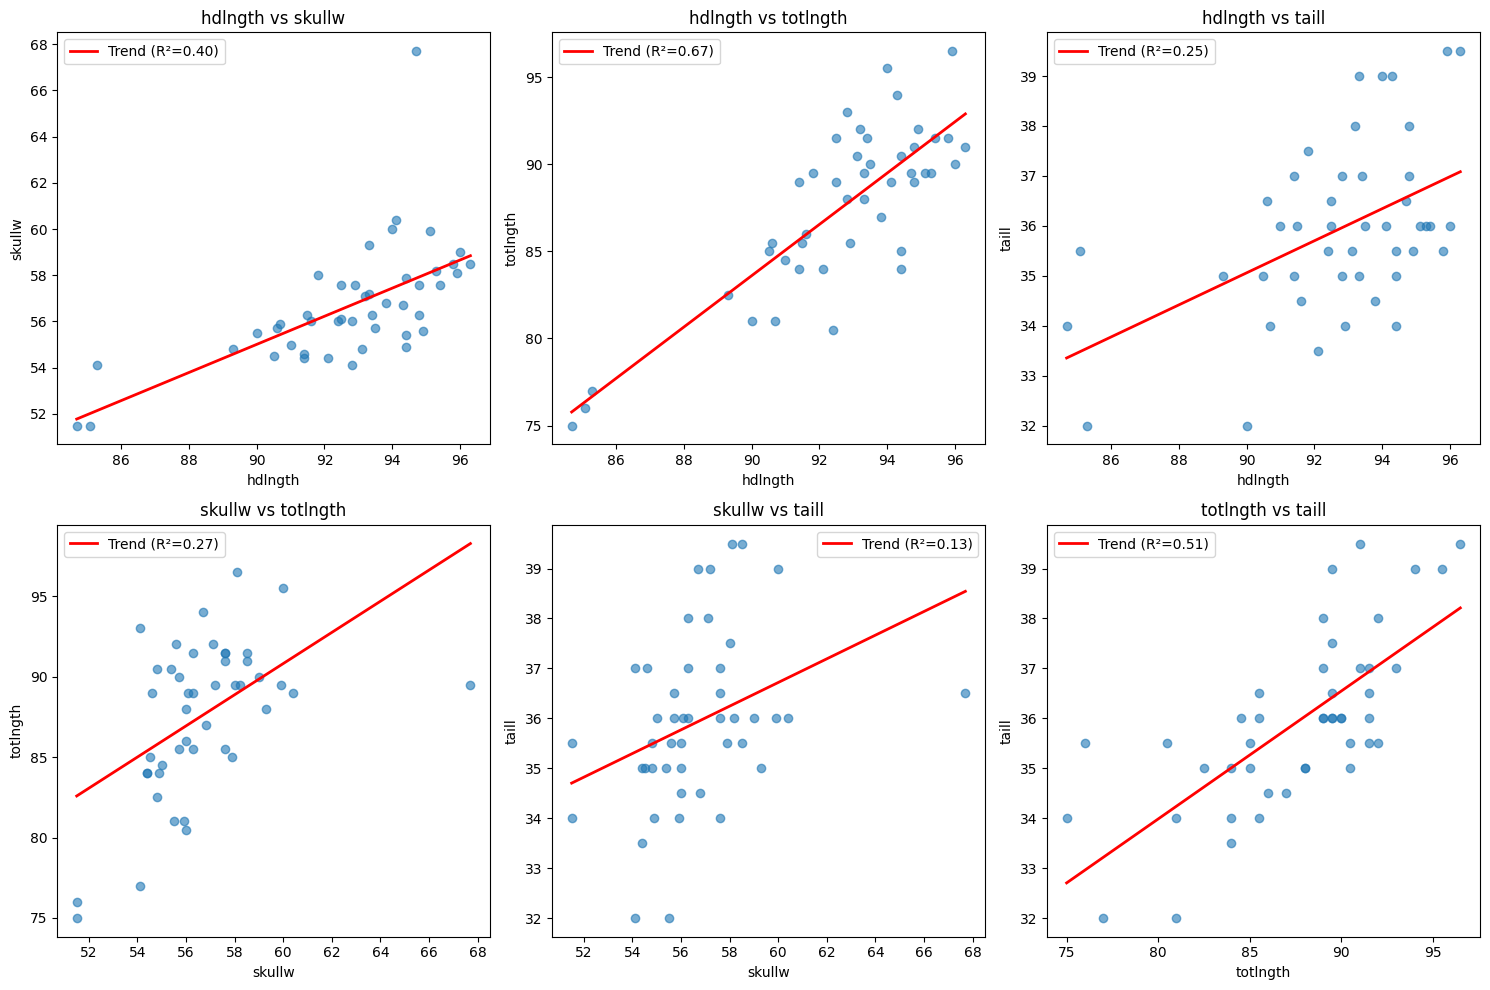

In [62]:
features = ['hdlngth', 'skullw', 'totlngth', 'taill']
pairs = list(combinations(features, 2))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ax = axes.flatten()

for i, (feature_x, feature_y) in enumerate(pairs):
    ax[i].scatter(vic_pop[feature_x], vic_pop[feature_y], alpha=0.6)
    
    # Add regression/trend line
    slope, intercept, r_value, _, _ = stats.linregress(vic_pop[feature_x], vic_pop[feature_y])
    line_x = np.linspace(vic_pop[feature_x].min(), vic_pop[feature_x].max(), 100)
    line_y = slope * line_x + intercept
    ax[i].plot(line_x, line_y, 'r-', linewidth=2, label=f'Trend (R²={r_value**2:.2f})')
    
    # # Mean lines
    # ax[i].axhline(female_pop[feature_y].mean(), color='green', linestyle='--', alpha=0.5, label='Mean Y')
    # ax[i].axvline(female_pop[feature_x].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean X')
    
    ax[i].set_xlabel(feature_x)
    ax[i].set_ylabel(feature_y)
    ax[i].set_title(f'{feature_x} vs {feature_y}')
    ax[i].legend()

plt.tight_layout()
plt.show()

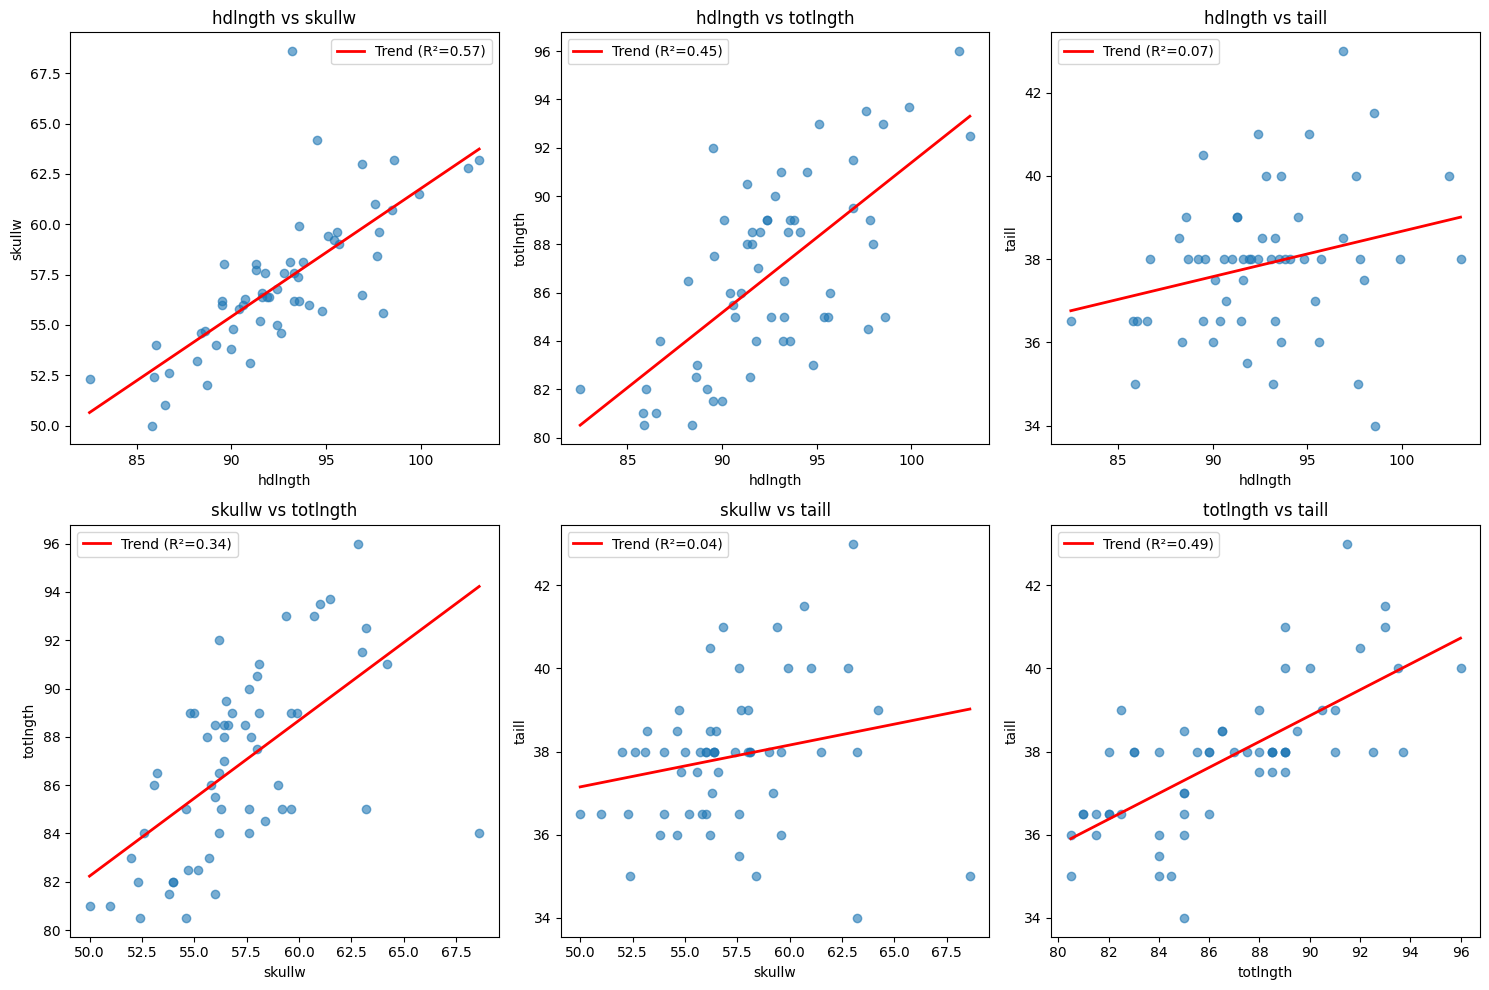

In [63]:
features = ['hdlngth', 'skullw', 'totlngth', 'taill']
pairs = list(combinations(features, 2))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ax = axes.flatten()

for i, (feature_x, feature_y) in enumerate(pairs):
    ax[i].scatter(other_pop[feature_x], other_pop[feature_y], alpha=0.6)
    
    # Add regression/trend line
    slope, intercept, r_value, _, _ = stats.linregress(other_pop[feature_x], other_pop[feature_y])
    line_x = np.linspace(other_pop[feature_x].min(), other_pop[feature_x].max(), 100)
    line_y = slope * line_x + intercept
    ax[i].plot(line_x, line_y, 'r-', linewidth=2, label=f'Trend (R²={r_value**2:.2f})')
    
    # # Mean lines
    # ax[i].axhline(female_pop[feature_y].mean(), color='green', linestyle='--', alpha=0.5, label='Mean Y')
    # ax[i].axvline(female_pop[feature_x].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean X')
    
    ax[i].set_xlabel(feature_x)
    ax[i].set_ylabel(feature_y)
    ax[i].set_title(f'{feature_x} vs {feature_y}')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [64]:
df

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,m,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,7,other,m,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,7,other,f,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,7,other,m,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


In [65]:
np.array(df.skullw)

array([60.4, 57.6, 60. , 57.1, 56.3, 54.8, 58.2, 57.6, 56.3, 58. , 57.2,
       55.6, 59.9, 57.6, 57.6, 56. , 67.7, 55.7, 55.4, 56.3, 58.1, 58.5,
       56.1, 54.9, 58.5, 59. , 54.5, 56.8, 56. , 54.4, 54.1, 56.7, 54.6,
       55.7, 57.9, 59.3, 54.8, 56. , 51.5, 55. , 54.1, 55.5, 51.5, 55.9,
       54.4, 54.8, 63.2, 59.2, 56.4, 59.6, 61. , 58.1, 63. , 63.2, 61.5,
       59.4, 64.2, 62.8, 57.7, 59. , 58. , 56.4, 56.5, 57.4, 55.8, 57.6,
       56. , 55.6, 56.4, 57.6, 52.4, 52.3, 52. , 58.1, 56.8, 56.2, 51. ,
       50. , 52.6, 56. , 54. , 53.8, 54.6, 56.2, 53.2, 60.7, 58. , 58.4,
       54.6, 59.6, 56.3, 54. , 57.6, 56.6, 55.7, 53.1, 68.6, 56.2, 56. ,
       54.7, 55. , 55.2, 59.9])

In [66]:
r, _  = stats.pearsonr(np.array(df.skullw),np.array(df.taill))

In [67]:
r

np.float64(0.2561024623055533)

In [68]:
corr_matrix = df.select_dtypes(include='float').corr()

In [69]:
corr_matrix.age.sort_values()

earconch    0.065772
taill       0.119109
footlgth    0.125548
eye         0.230931
totlngth    0.258330
skullw      0.280254
hdlngth     0.321749
chest       0.325912
belly       0.352037
age         1.000000
Name: age, dtype: float64

In [70]:
from scipy.stats import pointbiserialr

In [71]:
df['category_encoded'] = df['sex'].map({'m': 0, 'f': 1})

# Calculate correlation with each numeric feature
for col in df.select_dtypes(include='float'):
    corr, p_value = pointbiserialr(df['category_encoded'], df[col])
    print(f"{col}: correlation = {corr:.3f}, p-value = {p_value:.3f}")

age: correlation = 0.057, p-value = 0.565
hdlngth: correlation = -0.095, p-value = 0.341
skullw: correlation = -0.081, p-value = 0.416
totlngth: correlation = 0.173, p-value = 0.080
taill: correlation = 0.044, p-value = 0.657
footlgth: correlation = 0.124, p-value = 0.213
earconch: correlation = 0.117, p-value = 0.241
eye: correlation = -0.200, p-value = 0.043
chest: correlation = 0.140, p-value = 0.158
belly: correlation = 0.101, p-value = 0.312


In [72]:
df_test = df.copy()

In [73]:
from sklearn.preprocessing import LabelEncoder

In [74]:
sex_label = LabelEncoder()
df_test.sex = sex_label.fit_transform(df_test.sex)

In [75]:
df_test.drop('category_encoded', axis=1, inplace=True)

In [76]:
df_test

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,1,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,7,other,1,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,7,other,0,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,7,other,1,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


In [ ]:
correlation_matrix = df_test.select_dtypes(include=['float', 'int']).corr()

site        0.226876
sex         1.000000
age        -0.057327
hdlngth     0.094829
skullw      0.081008
totlngth   -0.173177
taill      -0.044259
footlgth   -0.123820
earconch   -0.116586
eye         0.199841
chest      -0.140042
belly      -0.100529
Name: sex, dtype: float64

In [88]:
correlation_matrix.sex.sort_values()

totlngth   -0.173177
chest      -0.140042
footlgth   -0.123820
earconch   -0.116586
belly      -0.100529
age        -0.057327
taill      -0.044259
skullw      0.081008
hdlngth     0.094829
eye         0.199841
site        0.226876
sex         1.000000
Name: sex, dtype: float64

For the first question we can see that there is a linear trend between total lenght and head lenght.

In [ ]:
print("Stopping execution here")
raise SystemExit("Execution stopped at this cell")

Stopping execution here


SystemExit: Execution stopped at this cell

/home/majid/Desktop/WebDev/machine-learning-projects/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### **For now target value is age**

In [ ]:
X = df.drop('age', axis= 1)
y = df.age

In [ ]:
X_labeld = pd.get_dummies(X, columns=['Pop', 'sex'])

In [ ]:
X_labeld

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_Vic,Pop_other,sex_f,sex_m
0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,True,False,False,True
1,1,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,True,False,True,False
2,1,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,True,False,True,False
3,1,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,True,False,True,False
4,1,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,False,True,False,True
100,7,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,False,True,False,True
101,7,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,False,True,True,False
102,7,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0,False,True,False,True


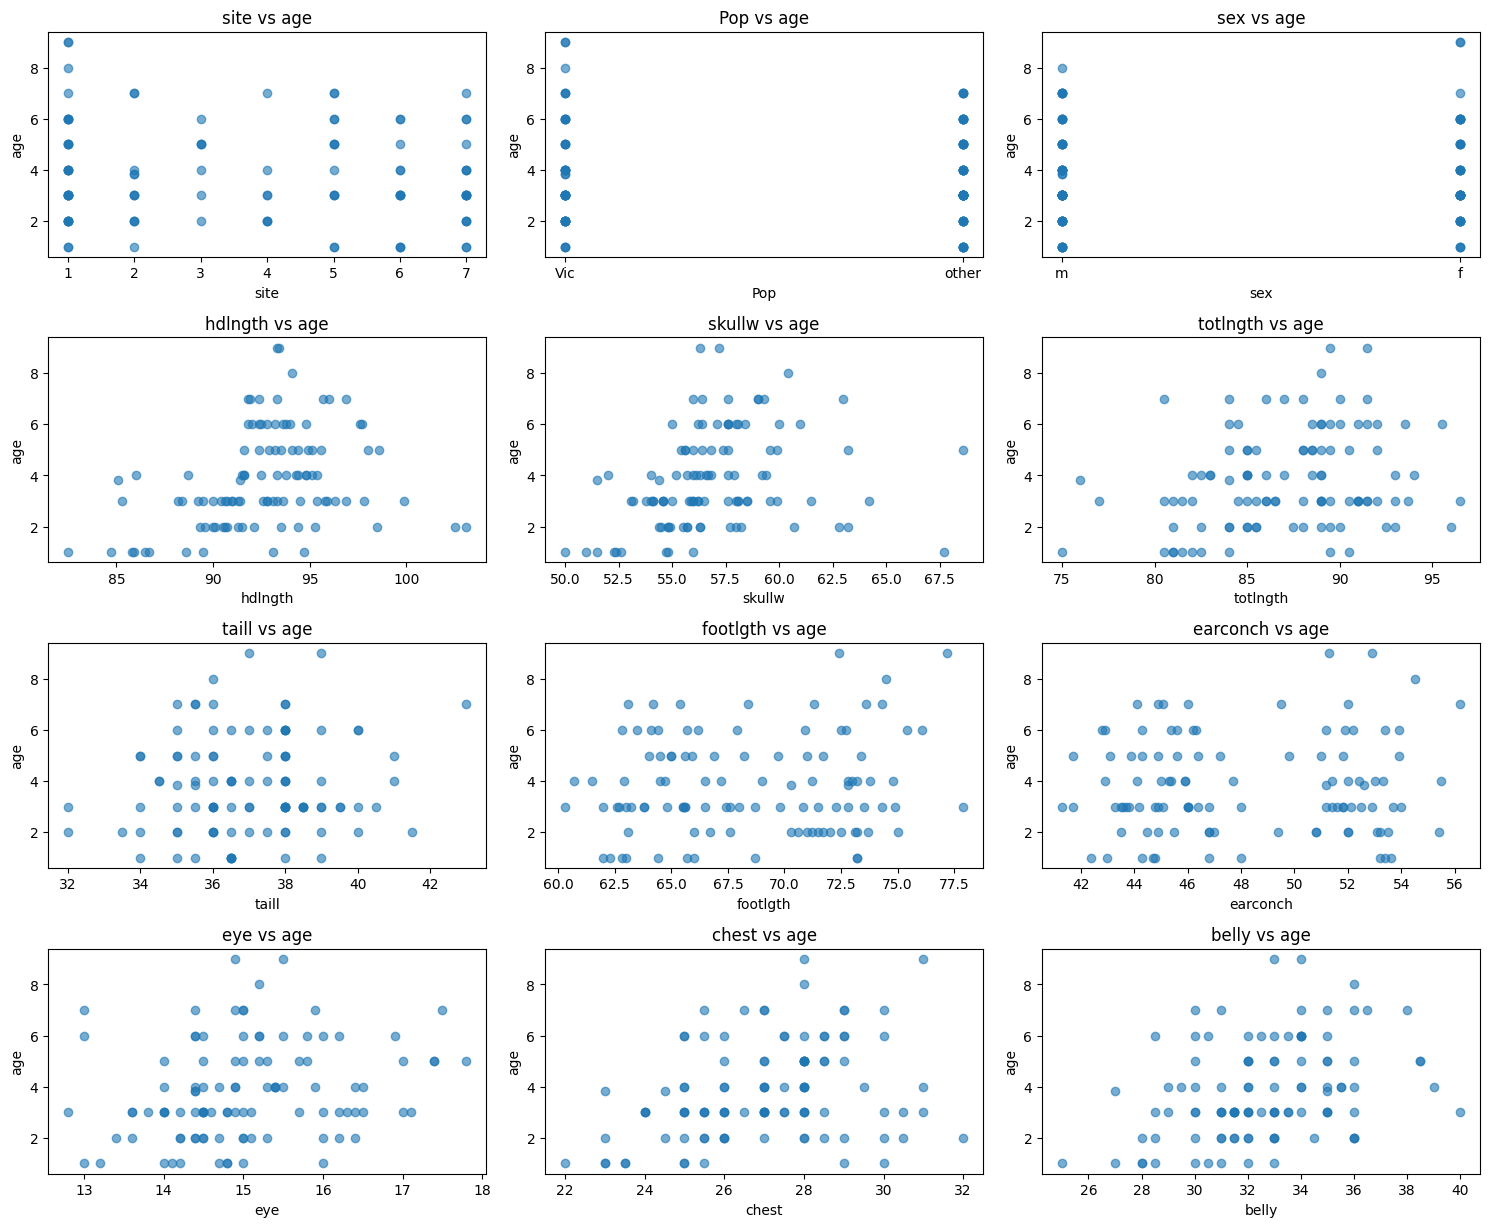

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
ax = axes.flatten()
feature_cols = [col for col in df.columns if col != 'age']

for i, feature in enumerate(feature_cols):
    ax[i].scatter(df[feature], df['age'], alpha=0.6)
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('age')
    ax[i].set_title(f'{feature} vs age')
for i in range(len(feature_cols), len(ax)):
    ax[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
pearson_analysis = X_labeld.copy()

In [ ]:
pearson_analysis['age'] = y

In [ ]:
corr_matrix = pearson_analysis.corr()

In [ ]:
print(corr_matrix['age'].sort_values(ascending=False))

age          1.000000
belly        0.352037
chest        0.325912
hdlngth      0.321749
skullw       0.280254
totlngth     0.258330
eye          0.230931
footlgth     0.125548
taill        0.119109
Pop_Vic      0.079624
earconch     0.065772
sex_f        0.057327
sex_m       -0.057327
Pop_other   -0.079624
site        -0.127150
Name: age, dtype: float64


In [ ]:
mutual_info = mutual_info_regression(X_labeld, y)

In [ ]:
mutual_info

array([0.        , 0.28616046, 0.14280076, 0.08986958, 0.06815351,
       0.        , 0.        , 0.        , 0.12992513, 0.        ,
       0.        , 0.        , 0.        , 0.06437757])

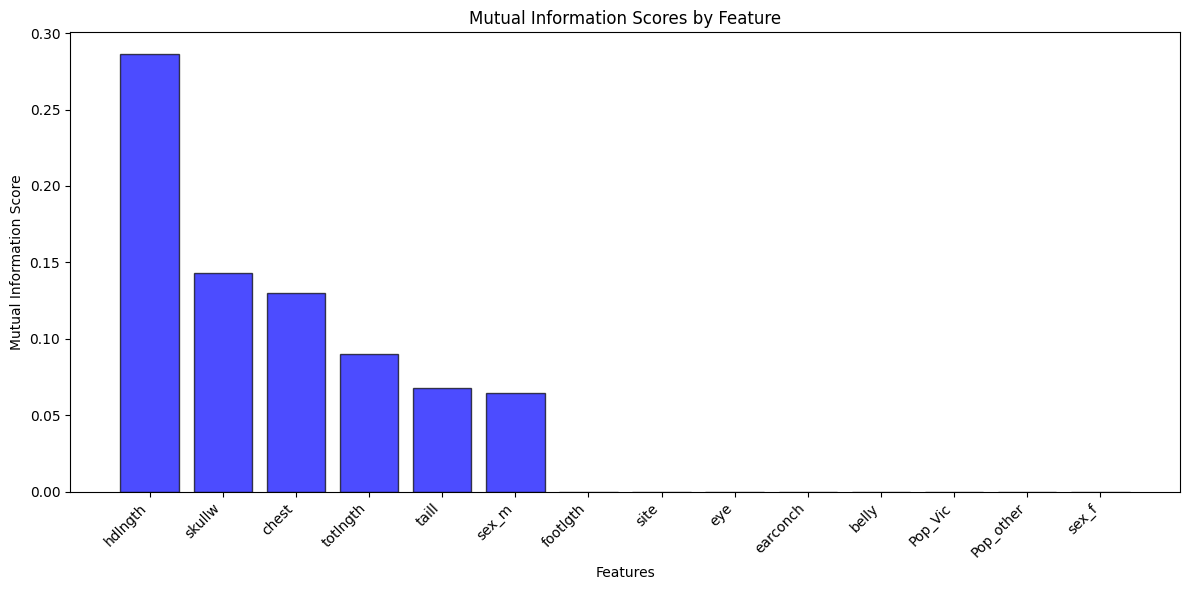

In [ ]:
mutual_info_series = pd.Series(mutual_info, index=X_labeld.columns, name='Mutual_Info')
mutual_info_sorted = mutual_info_series.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(mutual_info_sorted.index, mutual_info_sorted.values, 
        color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Simple modelling and analysis**

In [ ]:
lr = LinearRegression()

In [ ]:
scores = cross_val_score(
    lr, X_labeld, y, scoring='neg_mean_absolute_error', cv=5)

In [ ]:
scores = np.array([-2.12849853, -2.26501191, -1.69445374, -1.28598937, -1.54699262])

# Convert to actual MAE (positive values)
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
# Output: [2.12849853, 2.26501191, 1.69445374, 1.28598937, 1.54699262]

# Get the average performance
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [ ]:
from scipy.stats import normaltest, boxcox

In [ ]:
normal_test_features = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth','earconch', 'eye', 'chest', 'belly']
for i , val in enumerate(normal_test_features):
    print(f'{val} normal test is equale to {normaltest(X_labeld[val]).pvalue}')

hdlngth normal test is equale to 0.2119590756440955
skullw normal test is equale to 0.23465314007408547
totlngth normal test is equale to 0.42403766036563406
taill normal test is equale to 0.5253998798536322
footlgth normal test is equale to 2.6439511517378627e-08
earconch normal test is equale to 1.6054250432370557e-23
eye normal test is equale to 0.20784850421296983
chest normal test is equale to 0.8101776030495327
belly normal test is equale to 0.8361680686001689


In [ ]:
X_labeld.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 103
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   site       103 non-null    int64  
 1   hdlngth    103 non-null    float64
 2   skullw     103 non-null    float64
 3   totlngth   103 non-null    float64
 4   taill      103 non-null    float64
 5   footlgth   103 non-null    float64
 6   earconch   103 non-null    float64
 7   eye        103 non-null    float64
 8   chest      103 non-null    float64
 9   belly      103 non-null    float64
 10  Pop_Vic    103 non-null    bool   
 11  Pop_other  103 non-null    bool   
 12  sex_f      103 non-null    bool   
 13  sex_m      103 non-null    bool   
dtypes: bool(4), float64(9), int64(1)
memory usage: 9.3 KB


In [ ]:
# Convert booleans to integers
X_labeld['Pop_Vic'] = X_labeld['Pop_Vic'].astype(int)
X_labeld['Pop_other'] = X_labeld['Pop_other'].astype(int)
X_labeld['sex_f'] = X_labeld['sex_f'].astype(int)
X_labeld['sex_m'] = X_labeld['sex_m'].astype(int)

In [ ]:
dest_features = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth','earconch', 'eye', 'chest', 'belly']
def dest_plot(n, m , dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    # Plot each feature against target
    for i, feature in enumerate(dataset[dest_features]):
        ax[i].hist(df[feature], edgecolor='black', bins = 20)
        ax[i].set_xlabel(feature, color = 'red')
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')

    # Hide any empty subplots
    for i in range(len(dataset[dest_features]), len(ax)):
        ax[i].set_visible(False)

    plt.tight_layout()
    plt.show()


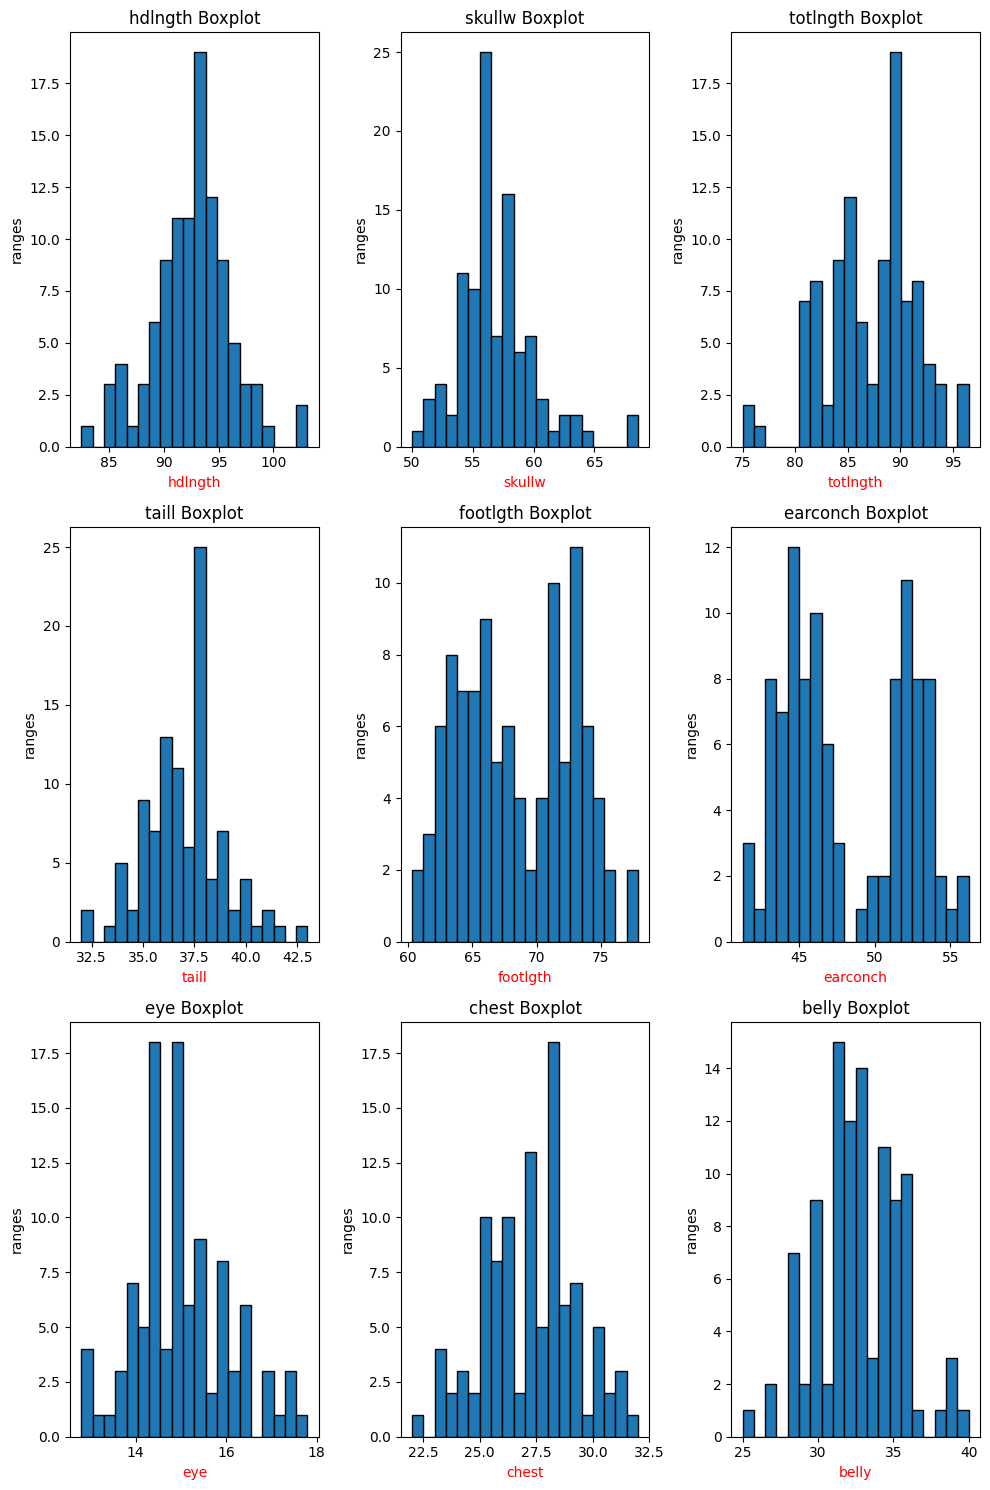

In [ ]:
dest_plot(3, 3, X_labeld)

In [ ]:
dest_features = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth','earconch', 'eye', 'chest', 'belly']
def dest_plot_log(n, m, dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    
    for i, feature in enumerate(dataset[dest_features]):
        ax[i].hist(df[feature], edgecolor='black', bins=20)
        ax[i].set_xlabel(feature, color='red')
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')
        ax[i].set_yscale('log')  # Log scale on Y-axis
    
    for i in range(len(dataset[dest_features]), len(ax)):
        ax[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

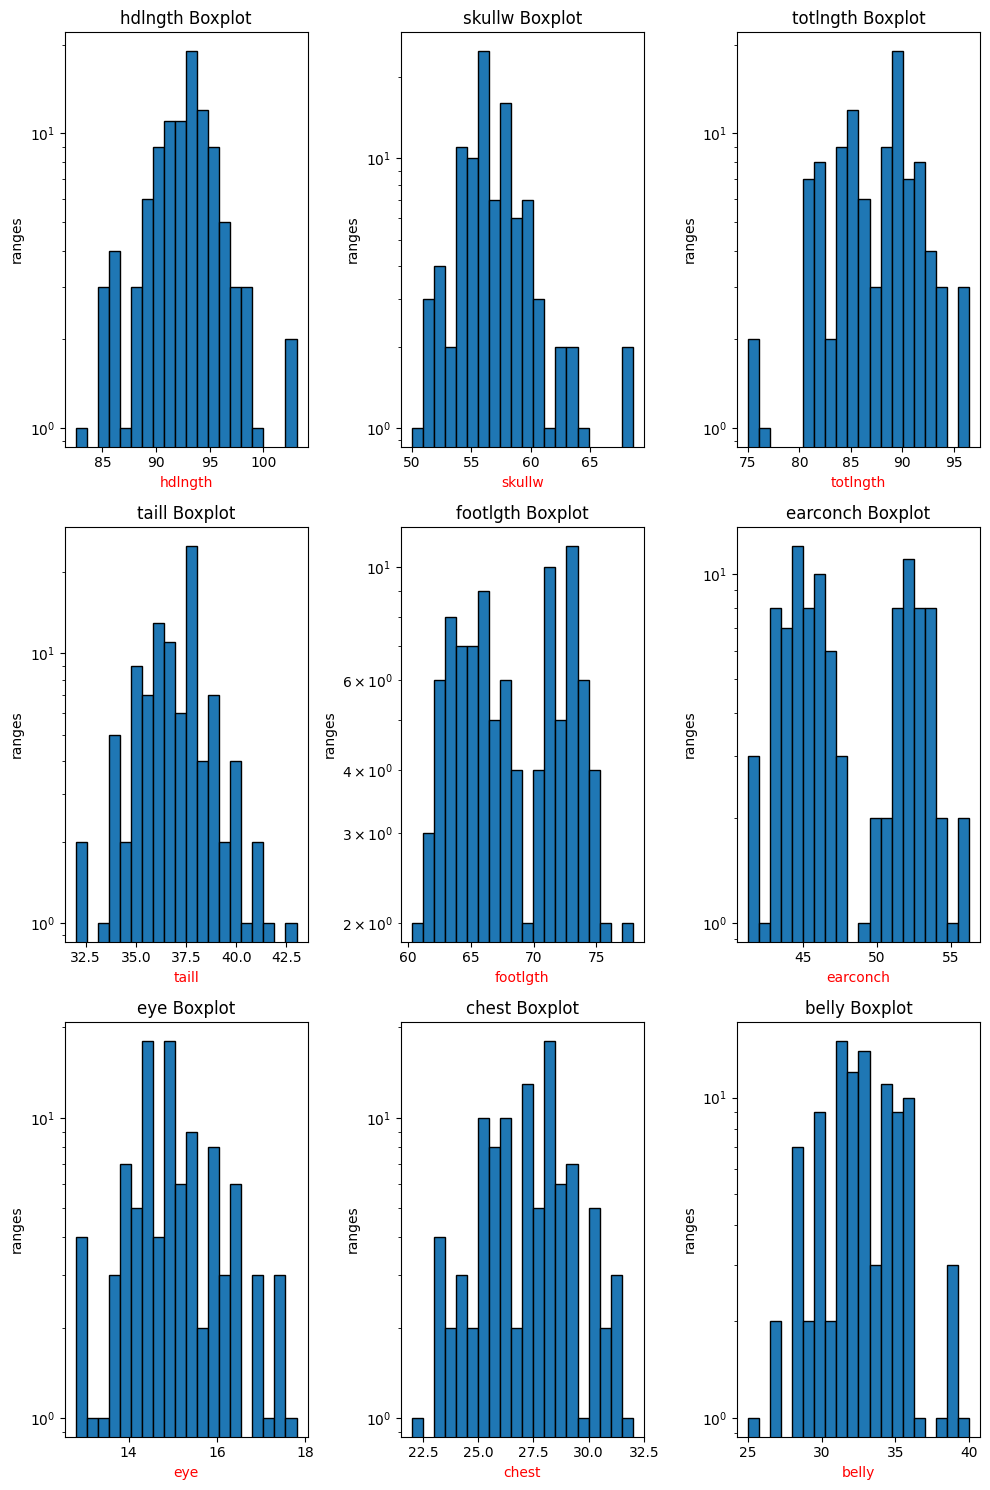

In [ ]:
dest_plot_log(3, 3, X_labeld)

In [ ]:
X.columns

Index(['site', 'Pop', 'sex', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [ ]:
X_labeld.skullw = boxcox(X_labeld.skullw)[0]

In [ ]:
scores_2 = cross_val_score(
    lr, X_labeld, y, scoring='neg_mean_absolute_error', cv=5)

In [ ]:
scores = np.array([-2.12849853, -2.26501191, -1.69445374, -1.28598937, -1.54699262])
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [ ]:
scores_2 = np.array([-2.12557357, -2.26337081, -1.69472629, -1.29262749, -1.54345071])
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [ ]:
X_labeld

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_Vic,Pop_other,sex_f,sex_m
0,1,94.1,0.301051,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,0,0,1
1,1,92.5,0.301051,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1,0,1,0
2,1,94.0,0.301051,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1,0,1,0
3,1,93.2,0.301051,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1,0,1,0
4,1,91.5,0.301051,85.5,36.0,71.0,53.2,15.1,28.5,33.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,89.5,0.301051,81.5,36.5,66.0,46.8,14.8,23.0,27.0,0,1,0,1
100,7,88.6,0.301051,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0,1,0,1
101,7,92.4,0.301051,89.0,38.0,63.5,45.4,13.0,25.0,30.0,0,1,1,0
102,7,91.5,0.301051,82.5,36.5,62.9,45.9,15.4,25.0,29.0,0,1,0,1


In [ ]:
lr.fit(X_labeld, y)
perm_importance = permutation_importance(lr, X_labeld, y, n_repeats=10, random_state=42, n_jobs=-1)

545.48s - Error patching args (debugger not attached to subprocess).
Traceback (most recent call last):
  File "/home/majid/Desktop/WebDev/machine-learning-projects/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/majid/Desktop/WebDev/machine-learning-projects/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
       ^^^^^^^^^^^^^^^^^^^^
TypeError: a bytes-like object is required, not 'str'
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_

In [ ]:
perm_importance.importances_mean

array([9.03456100e-02, 7.15307250e-02, 9.07423611e-02, 1.20085943e-02,
       8.17596844e-02, 3.82569708e-01, 7.46034185e-02, 4.58913058e-02,
       1.41630989e-02, 7.27857913e-02, 3.10740533e-01, 3.07099194e-01,
       5.13027008e-04, 3.49680962e-04])

In [ ]:
feature_names = [i for i in ['site','Pop_Vic','Pop_other','sex_f','sex_m','hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly']]

In [ ]:
linear_reg_importances = pd.Series(perm_importance.importances_mean, index=feature_names, name='Mutual_Info')

In [ ]:
linear_reg_importances

site         0.090346
Pop_Vic      0.071531
Pop_other    0.090742
sex_f        0.012009
sex_m        0.081760
hdlngth      0.382570
skullw       0.074603
totlngth     0.045891
taill        0.014163
footlgth     0.072786
earconch     0.310741
eye          0.307099
chest        0.000513
belly        0.000350
Name: Mutual_Info, dtype: float64

In [ ]:
dtr_importances = linear_reg_importances.sort_values(ascending=False)
dtr_importances.index

Index(['hdlngth', 'earconch', 'eye', 'Pop_other', 'site', 'sex_m', 'skullw',
       'footlgth', 'Pop_Vic', 'totlngth', 'taill', 'sex_f', 'chest', 'belly'],
      dtype='object')

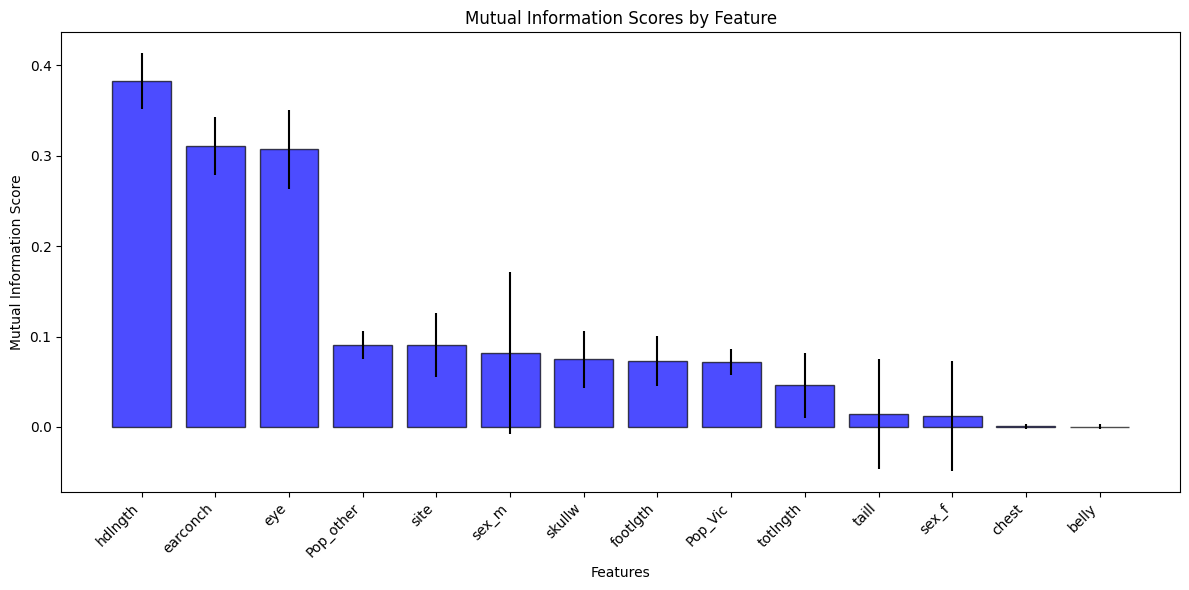

In [ ]:
# Sort for better visualization
dtr_importances = linear_reg_importances.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(dtr_importances.index, dtr_importances.values, 
        color='blue', edgecolor='black', alpha=0.7, yerr=perm_importance.importances_std)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbt = GradientBoostingRegressor()

In [ ]:
scores = cross_val_score(gbt, X_labeld, y, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
scores

array([-2.20099128, -1.60014104, -1.26127436, -1.32801442, -1.51917869])

In [ ]:
scores = np.array([-2.26738895, -1.4922026 , -1.30991233, -1.4543261 , -1.56943651])

# Convert to actual MAE (positive values)
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
# Output: [2.12849853, 2.26501191, 1.69445374, 1.28598937, 1.54699262]

# Get the average performance
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.26738895 1.4922026  1.30991233 1.4543261  1.56943651]
Mean MAE: 1.6187
Std MAE: 0.3351
